<a href="https://colab.research.google.com/github/Canihelpme/DeepLearning_finance/blob/main/Mnist_beans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "beans",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

In [8]:
lalala, info = tfds.load("beans",as_supervised=True, with_info=True)
class_names = info.features["label"].names
class_names

['angular_leaf_spot', 'bean_rust', 'healthy']

In [9]:
n_classes = info.features["label"].num_classes

In [10]:
dataset_size = info.splits["train"].num_examples
dataset_size

1034

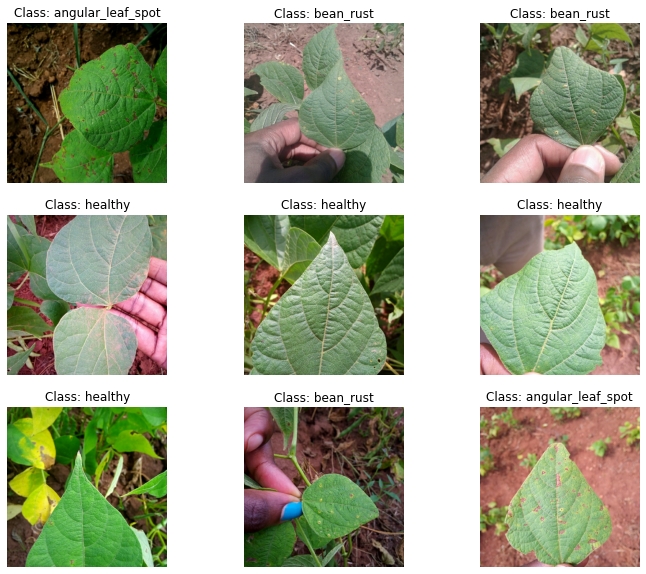

In [11]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [45]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [46]:
from functools import *

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    return resized_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat(3)
#train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

#Fashion Mnist CNN

In [17]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=5, activation='relu'),
])

In [20]:
from keras.callbacks import EarlyStopping

early_stopping = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5)]

In [23]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs = 40, callbacks = [early_stopping])
model.evaluate(test_set)
model.summary()

Epoch 1/40
73/73 [==============================] - 12s 125ms/step - loss: 4.9827 - accuracy: 0.3144 - val_loss: 1.0986 - val_accuracy: 0.3355
Epoch 2/40
73/73 [==============================] - 9s 122ms/step - loss: 4.4449 - accuracy: 0.3222 - val_loss: 1.0986 - val_accuracy: 0.3355
Epoch 3/40
73/73 [==============================] - 9s 124ms/step - loss: 4.6179 - accuracy: 0.3153 - val_loss: 1.0986 - val_accuracy: 0.3355
Epoch 4/40
73/73 [==============================] - 9s 121ms/step - loss: 4.5299 - accuracy: 0.3153 - val_loss: 1.0986 - val_accuracy: 0.3355
Epoch 5/40
73/73 [==============================] - 9s 121ms/step - loss: 4.6148 - accuracy: 0.2960 - val_loss: 1.0986 - val_accuracy: 0.3355
Epoch 6/40
73/73 [==============================] - 9s 121ms/step - loss: 4.5339 - accuracy: 0.3046 - val_loss: 1.0986 - val_accuracy: 0.3355


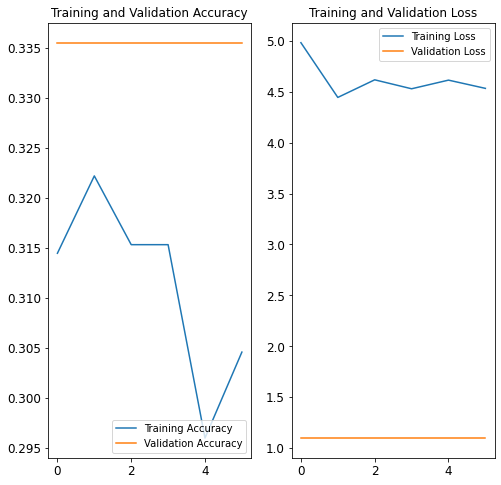

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = 6
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#2번

In [37]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

history = model.fit(train_set, epochs = 10, validation_data=valid_set,callbacks = [early_stopping])
model.evaluate(test_set)
model.summary()

Epoch 1/10
73/73 [==============================] - 17s 198ms/step - loss: 37.4035 - accuracy: 0.4021 - val_loss: 1.0141 - val_accuracy: 0.5097
Epoch 2/10
73/73 [==============================] - 13s 183ms/step - loss: 1.4750 - accuracy: 0.5142 - val_loss: 0.9684 - val_accuracy: 0.4839
Epoch 3/10
73/73 [==============================] - 13s 183ms/step - loss: 12.1237 - accuracy: 0.4725 - val_loss: 1.5085 - val_accuracy: 0.3806
Epoch 4/10
73/73 [==============================] - 13s 183ms/step - loss: 7.1214 - accuracy: 0.3836 - val_loss: 1.0402 - val_accuracy: 0.4839
Epoch 5/10
73/73 [==============================] - 13s 183ms/step - loss: 1.0877 - accuracy: 0.4549 - val_loss: 0.9759 - val_accuracy: 0.5548
Epoch 6/10
73/73 [==============================] - 13s 183ms/step - loss: 1.0194 - accuracy: 0.4888 - val_loss: 0.9096 - val_accuracy: 0.5871
Epoch 7/10
73/73 [==============================] - 13s 183ms/step - loss: 1.0283 - accuracy: 0.5168 - val_loss: 0.8603 - val_accuracy: 0.58

[0.8196297287940979, 0.582524299621582]

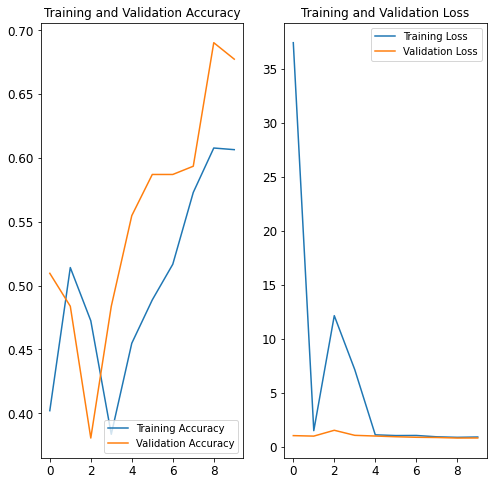

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = 10
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

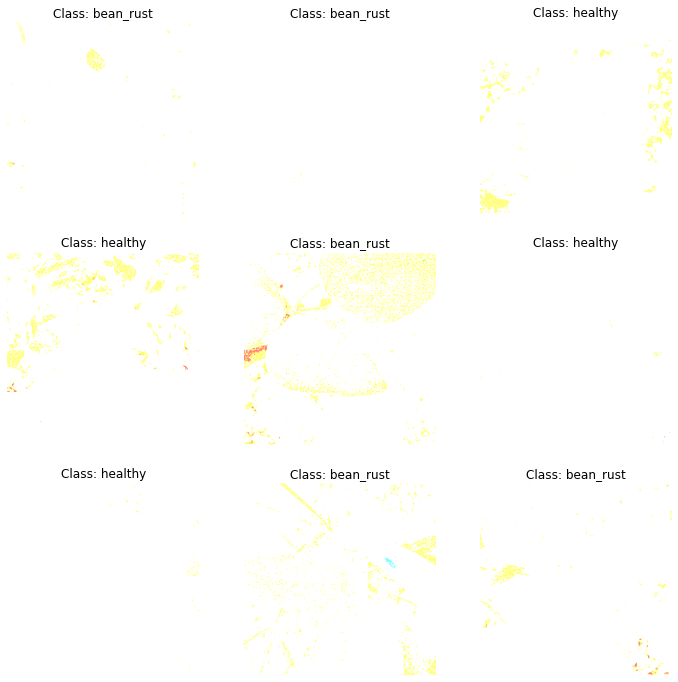

In [62]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

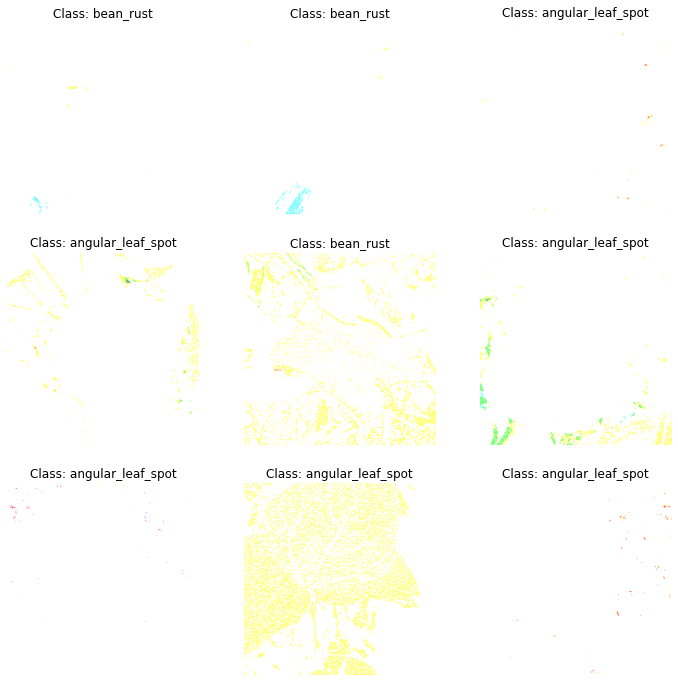

In [63]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

#3번

In [64]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [65]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_4
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_8
13 block2_pool
14 batch_normalization_4
15 add_12
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_9
23 block3_pool
24 batch_normalization_5
25 add_13
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_10
33 block4_pool
34 batch_normalization_6
35 add_14
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_15
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_s

In [66]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)
model.evaluate(test_set)
model.summary()

Epoch 1/5
24/24 [==============================] - 5s 125ms/step - loss: 8112.5474 - accuracy: 0.4010 - val_loss: 3735.2642 - val_accuracy: 0.5078
Epoch 2/5
24/24 [==============================] - 2s 92ms/step - loss: 6163.9980 - accuracy: 0.4661 - val_loss: 6546.2466 - val_accuracy: 0.4688
Epoch 3/5
24/24 [==============================] - 2s 91ms/step - loss: 4308.7759 - accuracy: 0.5195 - val_loss: 4224.9707 - val_accuracy: 0.4922
Epoch 4/5
 1/24 [>.............................] - ETA: 1s - loss: 7710.2915 - accuracy: 0.2500WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 120 batches). You may need to use the repeat() function when building your dataset.


24/24 [==============================] - 0s 16ms/step - loss: 7710.2915 - accuracy: 0.2500 - val_loss: 3004.3740 - val_accuracy: 0.5234
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_4[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   1

In [67]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)
model.evaluate(test_set)
model.summary()

Epoch 1/40
24/24 [==============================] - 44s 443ms/step - loss: 6.3252 - accuracy: 0.4010 - val_loss: 1526266368.0000 - val_accuracy: 0.3359
Epoch 2/40
24/24 [==============================] - 9s 390ms/step - loss: 1.1363 - accuracy: 0.3372 - val_loss: 11960268.0000 - val_accuracy: 0.3047
Epoch 3/40
24/24 [==============================] - 9s 388ms/step - loss: 1.1165 - accuracy: 0.3281 - val_loss: 109993.4297 - val_accuracy: 0.3047
Epoch 4/40
 1/24 [>.............................] - ETA: 6s - loss: 1.0946 - accuracy: 0.5000WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 960 batches). You may need to use the repeat() function when building your dataset.


24/24 [==============================] - 1s 17ms/step - loss: 1.0946 - accuracy: 0.5000 - val_loss: 99383.5547 - val_accuracy: 0.3047


#4번

In [77]:
base_model2 = keras.applications.resnet50.ResNet50(weights="imagenet")
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [78]:
for index, layer in enumerate(base_model2.layers):
    print(index, layer.name)

0 input_7
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [80]:
for layer in base_model2.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)
model.evaluate(test_set)
model.summary()

Epoch 1/5
24/24 [==============================] - 14s 415ms/step - loss: 1.1035 - accuracy: 0.3385 - val_loss: 1.1066 - val_accuracy: 0.3438
Epoch 2/5
24/24 [==============================] - 9s 386ms/step - loss: 1.1141 - accuracy: 0.3268 - val_loss: 1.1000 - val_accuracy: 0.3594
Epoch 3/5
24/24 [==============================] - 9s 387ms/step - loss: 1.1111 - accuracy: 0.3086 - val_loss: 1.0953 - val_accuracy: 0.3594
Epoch 4/5
 1/24 [>.............................] - ETA: 6s - loss: 1.0882 - accuracy: 0.4167WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 120 batches). You may need to use the repeat() function when building your dataset.


4/4 [==============================] - 0s 116ms/step - loss: 1.1003 - accuracy: 0.3398
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_4[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 atio

In [81]:
for layer in base_model2.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)
model.evaluate(test_set)
model.summary()

Epoch 1/40
24/24 [==============================] - 14s 418ms/step - loss: 1.1028 - accuracy: 0.3359 - val_loss: 1.0967 - val_accuracy: 0.3594
Epoch 2/40
24/24 [==============================] - 9s 387ms/step - loss: 1.0997 - accuracy: 0.3359 - val_loss: 1.0988 - val_accuracy: 0.3594
Epoch 3/40
24/24 [==============================] - 9s 386ms/step - loss: 1.0996 - accuracy: 0.3294 - val_loss: 1.0982 - val_accuracy: 0.3594
Epoch 4/40
 1/24 [>.............................] - ETA: 6s - loss: 1.1015 - accuracy: 0.2083WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 960 batches). You may need to use the repeat() function when building your dataset.


4/4 [==============================] - 0s 58ms/step - loss: 1.0988 - accuracy: 0.3301
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_4[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation